## 1. Loading test images

In [ ]:
#Importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import os
import glob
from moviepy.editor import VideoFileClip

%matplotlib inline

In [2]:
def list_images(images, cols = 2, rows = 5, cmap=None):
    """
    Display a list of images in a single figure with matplotlib.
        Parameters:
            images: List of np.arrays compatible with plt.imshow.
            cols (Default = 2): Number of columns in the figure.
            rows (Default = 5): Number of rows in the figure.
            cmap (Default = None): Used to display gray images.
    """
    plt.figure(figsize=(10, 11))
    for i, image in enumerate(images):
        plt.subplot(rows, cols, i+1)
        #Use gray scale color map if there is only one channel
        cmap = 'gray' if len(image.shape) == 2 else cmap
        plt.imshow(image, cmap = cmap)
        plt.xticks([])
        plt.yticks([])
    plt.tight_layout(pad=0, h_pad=0, w_pad=0)
    plt.show()

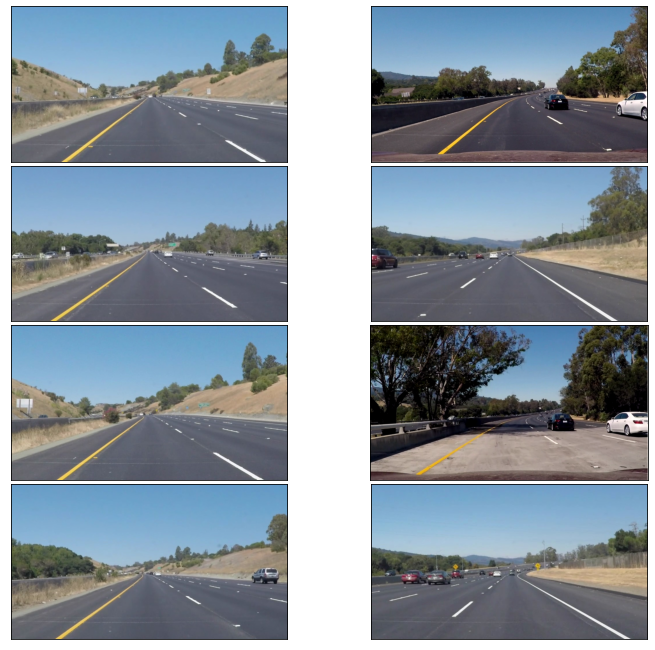

In [9]:
#Reading in the test images
test_images = [plt.imread(img) for img in glob.glob('test_images/*.jpg')]
list_images(test_images)

## 2. Color Selection

In [10]:
def RGB_color_selection(image):
    """
    Apply color selection to RGB images to blackout everything except for white and yellow lane lines.
        Parameters:
            image: An np.array compatible with plt.imshow.
    """
    #White color mask
    lower_threshold = np.uint8([200, 200, 200])
    upper_threshold = np.uint8([255, 255, 255])
    white_mask = cv2.inRange(image, lower_threshold, upper_threshold)
    
    #Yellow color mask
    lower_threshold = np.uint8([175, 175,   0])
    upper_threshold = np.uint8([255, 255, 255])
    yellow_mask = cv2.inRange(image, lower_threshold, upper_threshold)
    
    #Combine white and yellow masks
    mask = cv2.bitwise_or(white_mask, yellow_mask)
    masked_image = cv2.bitwise_and(image, image, mask = mask)
    
    return masked_image

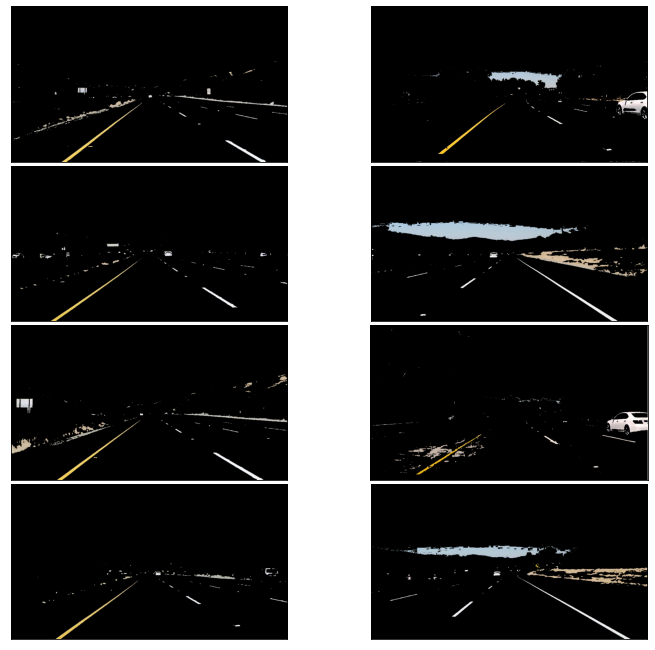

In [11]:
list_images(list(map(RGB_color_selection, test_images)))

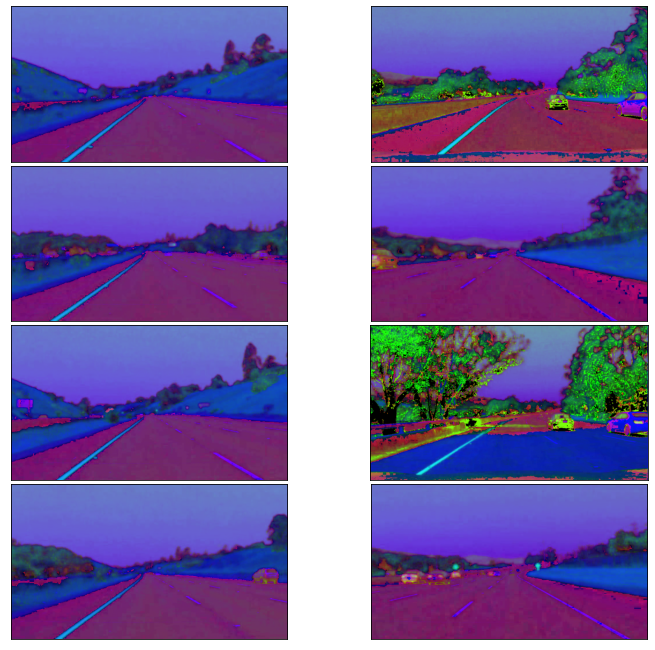

In [12]:
def convert_hsv(image):
    """
    Convert RGB images to HSV.
        Parameters:
            image: An np.array compatible with plt.imshow.
    """
    return cv2.cvtColor(image, cv2.COLOR_RGB2HSV)

list_images(list(map(convert_hsv, test_images)))

In [13]:
def HSV_color_selection(image):
    """
    Apply color selection to the HSV images to blackout everything except for white and yellow lane lines.
        Parameters:
            image: An np.array compatible with plt.imshow.
    """
    #Convert the input image to HSV
    converted_image = convert_hsv(image)
    
    #White color mask
    lower_threshold = np.uint8([0, 0, 210])
    upper_threshold = np.uint8([255, 30, 255])
    white_mask = cv2.inRange(converted_image, lower_threshold, upper_threshold)
    
    #Yellow color mask
    lower_threshold = np.uint8([18, 80, 80])
    upper_threshold = np.uint8([30, 255, 255])
    yellow_mask = cv2.inRange(converted_image, lower_threshold, upper_threshold)
    
    #Combine white and yellow masks
    mask = cv2.bitwise_or(white_mask, yellow_mask)
    masked_image = cv2.bitwise_and(image, image, mask = mask)
    
    return masked_image

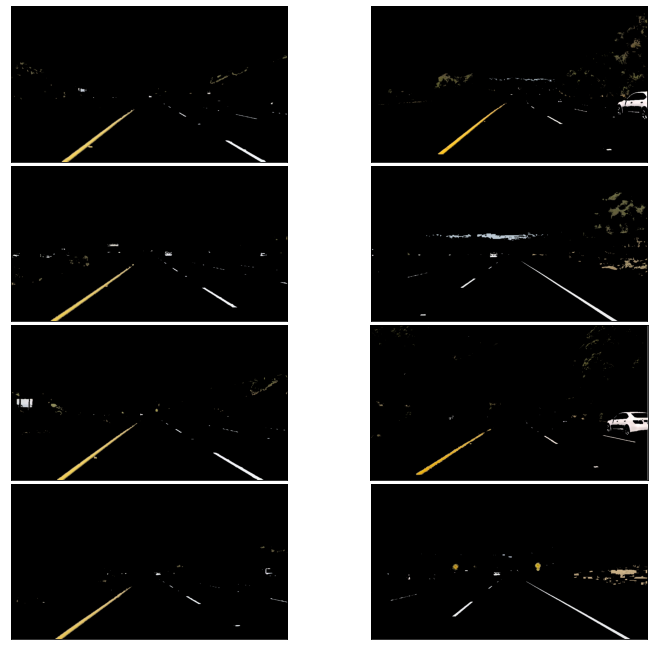

In [14]:
list_images(list(map(HSV_color_selection, test_images)))

In [16]:
def HSL_color_selection(image):
    """
    Apply color selection to the HSL images to blackout everything except for white and yellow lane lines.
        Parameters:
            image: An np.array compatible with plt.imshow.
    """
    #Convert the input image to HSL
    converted_image = convert_hsl(image)
    
    #White color mask
    lower_threshold = np.uint8([0, 200, 0])
    upper_threshold = np.uint8([255, 255, 255])
    white_mask = cv2.inRange(converted_image, lower_threshold, upper_threshold)
    
    #Yellow color mask
    lower_threshold = np.uint8([10, 0, 100])
    upper_threshold = np.uint8([40, 255, 255])
    yellow_mask = cv2.inRange(converted_image, lower_threshold, upper_threshold)
    
    #Combine white and yellow masks
    mask = cv2.bitwise_or(white_mask, yellow_mask)
    masked_image = cv2.bitwise_and(image, image, mask = mask)
    
    return masked_image

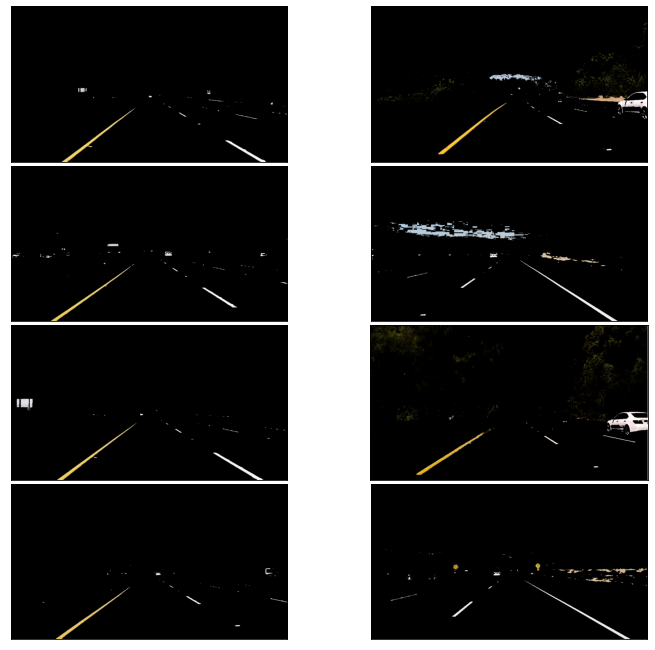

In [17]:
list_images(list(map(HSL_color_selection, test_images)))

In [18]:
color_selected_images = list(map(HSL_color_selection, test_images))

## 3. Canny Edge Detection

In [19]:
def gray_scale(image):
    """
    Convert images to gray scale.
        Parameters:
            image: An np.array compatible with plt.imshow.
    """
    return cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

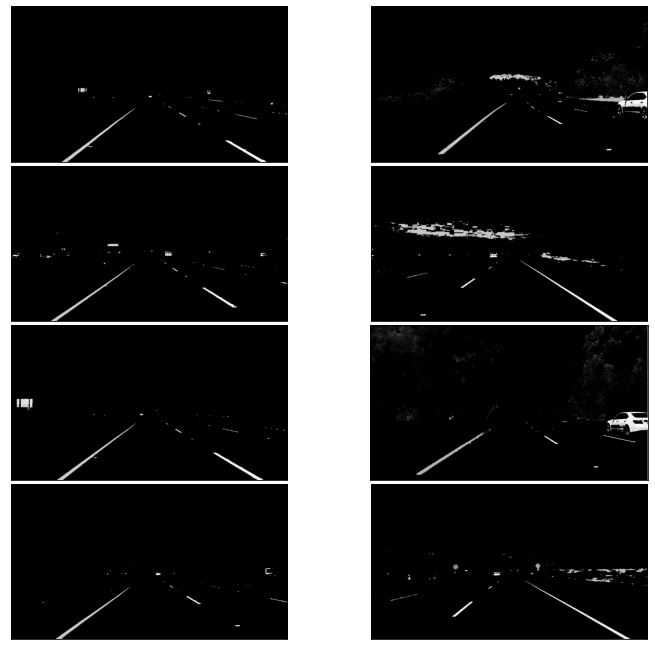

In [22]:
gray_images = list(map(gray_scale, color_selected_images))
list_images(gray_images)

In [23]:
def gaussian_smoothing(image, kernel_size = 13):
    """
    Apply Gaussian filter to the input image.
        Parameters:
            image: An np.array compatible with plt.imshow.
            kernel_size (Default = 13): The size of the Gaussian kernel will affect the performance of the detector.
            It must be an odd number (3, 5, 7, ...).
    """
    return cv2.GaussianBlur(image, (kernel_size, kernel_size), 0)

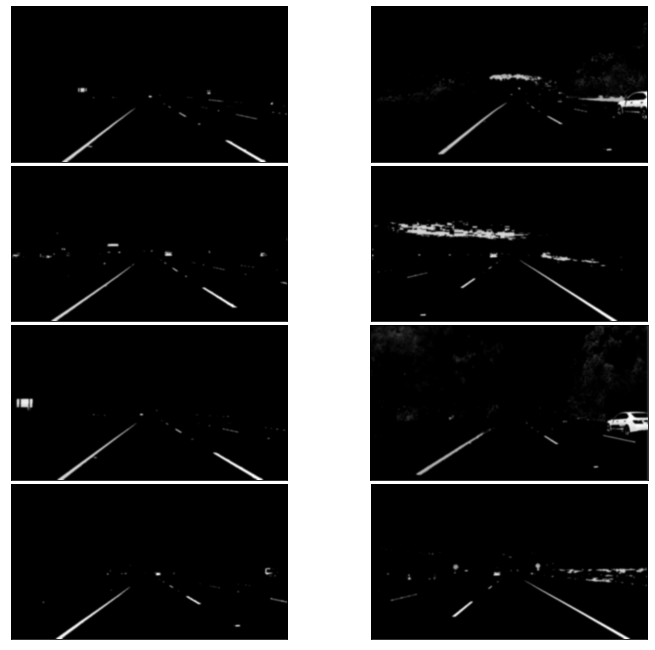

In [24]:
blur_images = list(map(gaussian_smoothing, gray_images))
list_images(blur_images)

In [25]:
def canny_detector(image, low_threshold = 50, high_threshold = 150):
    """
    Apply Canny Edge Detection algorithm to the input image.
        Parameters:
            image: An np.array compatible with plt.imshow.
            low_threshold (Default = 50).
            high_threshold (Default = 150).
    """
    return cv2.Canny(image, low_threshold, high_threshold)

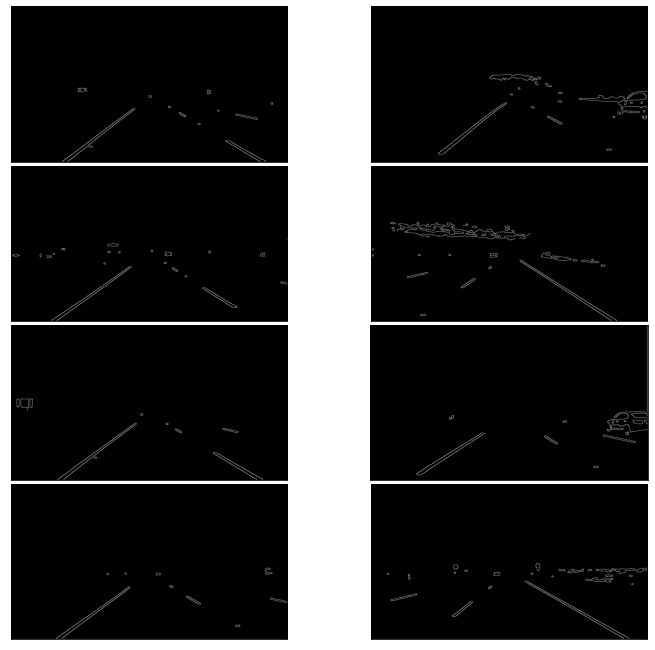

In [26]:
edge_detected_images = list(map(canny_detector, blur_images))
list_images(edge_detected_images)

In [28]:
def region_selection(image):
    """
    Determine and cut the region of interest in the input image.
        Parameters:
            image: An np.array compatible with plt.imshow.
    """
    mask = np.zeros_like(image)   
    #Defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(image.shape) > 2:
        channel_count = image.shape[2]
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
    #We could have used fixed numbers as the vertices of the polygon,
    #but they will not be applicable to images with different dimesnions.
    rows, cols = image.shape[:2]
    bottom_left  = [cols * 0.1, rows * 0.95]
    top_left     = [cols * 0.4, rows * 0.6]
    bottom_right = [cols * 0.9, rows * 0.95]
    top_right    = [cols * 0.6, rows * 0.6]
    vertices = np.array([[bottom_left, top_left, top_right, bottom_right]], dtype=np.int32)
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    masked_image = cv2.bitwise_and(image, mask)
    return masked_image

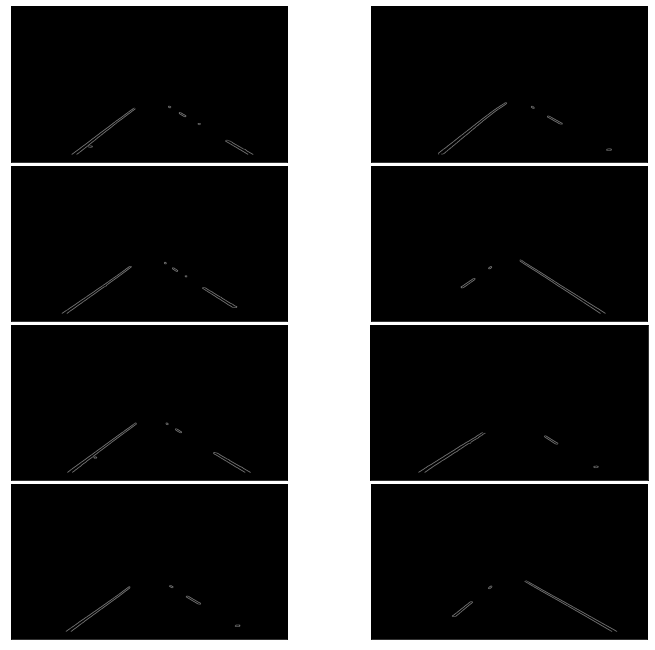

In [29]:
masked_image = list(map(region_selection, edge_detected_images))
list_images(masked_image)

In [1]:
def hough_transform(image):
    """
    Determine and cut the region of interest in the input image.
        Parameters:
            image: The output of a Canny transform.
    """
    rho = 1              #Distance resolution of the accumulator in pixels.
    theta = np.pi/180    #Angle resolution of the accumulator in radians.
    threshold = 20       #Only lines that are greater than threshold will be returned.
    minLineLength = 20   #Line segments shorter than that are rejected.
    maxLineGap = 300     #Maximum allowed gap between points on the same line to link them
    return cv2.HoughLinesP(image, rho = rho, theta = theta, threshold = threshold,
                           minLineLength = minLineLength, maxLineGap = maxLineGap)

In [31]:
hough_lines = list(map(hough_transform, masked_image))

In [32]:
def draw_lines(image, lines, color = [255, 0, 0], thickness = 2):
    """
    Draw lines onto the input image.
        Parameters:
            image: An np.array compatible with plt.imshow.
            lines: The lines we want to draw.
            color (Default = red): Line color.
            thickness (Default = 2): Line thickness.
    """
    image = np.copy(image)
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(image, (x1, y1), (x2, y2), color, thickness)
    return image

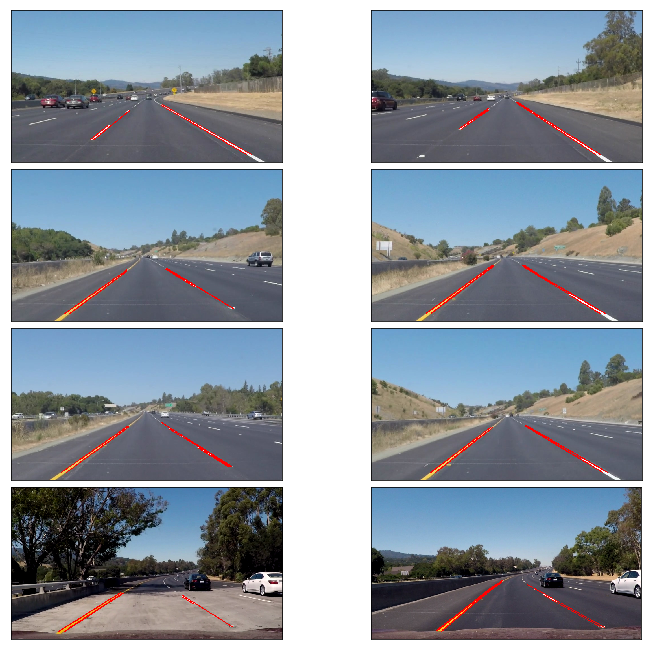

In [24]:
line_images = []
for image, lines in zip(test_images, hough_lines):
    line_images.append(draw_lines(image, lines))
    
list_images(line_images)

## 6. Averaging and extrapolating the lane lines

In [33]:
def average_slope_intercept(lines):
    """
    Find the slope and intercept of the left and right lanes of each image.
        Parameters:
            lines: The output lines from Hough Transform.
    """
    left_lines    = [] #(slope, intercept)
    left_weights  = [] #(length,)
    right_lines   = [] #(slope, intercept)
    right_weights = [] #(length,)
    
    for line in lines:
        for x1, y1, x2, y2 in line:
            if x1 == x2:
                continue
            slope = (y2 - y1) / (x2 - x1)
            intercept = y1 - (slope * x1)
            length = np.sqrt(((y2 - y1) ** 2) + ((x2 - x1) ** 2))
            if slope < 0:
                left_lines.append((slope, intercept))
                left_weights.append((length))
            else:
                right_lines.append((slope, intercept))
                right_weights.append((length))
    left_lane  = np.dot(left_weights,  left_lines) / np.sum(left_weights)  if len(left_weights) > 0 else None
    right_lane = np.dot(right_weights, right_lines) / np.sum(right_weights) if len(right_weights) > 0 else None
    return left_lane, right_lane

In [34]:
def pixel_points(y1, y2, line):
    """
    Converts the slope and intercept of each line into pixel points.
        Parameters:
            y1: y-value of the line's starting point.
            y2: y-value of the line's end point.
            line: The slope and intercept of the line.
    """
    if line is None:
        return None
    slope, intercept = line
    x1 = int((y1 - intercept)/slope)
    x2 = int((y2 - intercept)/slope)
    y1 = int(y1)
    y2 = int(y2)
    return ((x1, y1), (x2, y2))

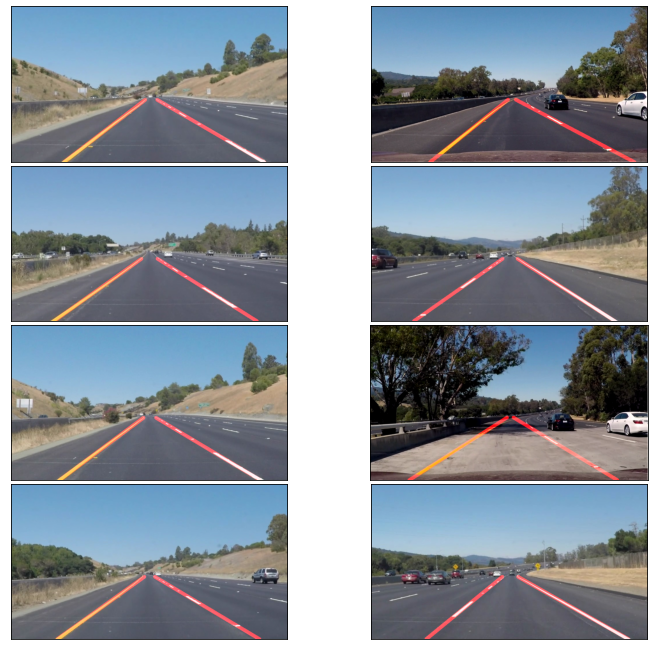

In [35]:
def lane_lines(image, lines):
    """
    Create full lenght lines from pixel points.
        Parameters:
            image: The input test image.
            lines: The output lines from Hough Transform.
    """
    left_lane, right_lane = average_slope_intercept(lines)
    y1 = image.shape[0]
    y2 = y1 * 0.6
    left_line  = pixel_points(y1, y2, left_lane)
    right_line = pixel_points(y1, y2, right_lane)
    return left_line, right_line

    
def draw_lane_lines(image, lines, color=[255, 0, 0], thickness=12):
    """
    Draw lines onto the input image.
        Parameters:
            image: The input test image.
            lines: The output lines from Hough Transform.
            color (Default = red): Line color.
            thickness (Default = 12): Line thickness. 
    """
    line_image = np.zeros_like(image)
    for line in lines:
        if line is not None:
            cv2.line(line_image, *line,  color, thickness)
    return cv2.addWeighted(image, 1.0, line_image, 1.0, 0.0)
             
    
lane_images = []
for image, lines in zip(test_images, hough_lines):
    lane_images.append(draw_lane_lines(image, lane_lines(image, lines)))

    
list_images(lane_images)